## ref
- <https://github.com/miruetoto/yechan3/tree/main/posts/3_Researches/ITSTGCN/itstgcn>
- <https://miruetoto.github.io/yechan3/posts/3_Researches/ITSTGCN/2023-03-18-SimulationPlanner-Tutorial.html#plnr_gnar_block>

## 2022/06/01 ~ 2022/09/15

- train 2022-06-01 00:00:00 ~ 2022-08-14 17:00:00
- test 2022-08-14 18:00:00 ~ 2022-09-15 23:00:00

## import

In [1]:
import eptstgcn
import torch
import eptstgcn.planner

In [2]:
# # 일반적인 모듈 
# import numpy as np
# import matplotlib.pyplot as plt 
# import networkx as nx 
# from tqdm import tqdm 

# # 파이토치 관련 
# import torch
# import torch.nn.functional as F

# # PyG 관련 
# from torch_geometric.data import Data ## Data: 그래프자료형을 만드는 클래스

# # STGCN 관련 
# import torch_geometric_temporal
# from torch_geometric_temporal.nn.recurrent import GConvGRU
# from torch_geometric_temporal.signal import temporal_signal_split 

# STGCN test

In [2]:
url = "https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data2/stgcn_data1.json"
loader = eptstgcn.DatasetLoader(url)
dataset = loader.get_dataset(lags=4)

In [12]:
plans_stgcn = {
    'max_iteration': 2, 
    'method': ['STGCN'], 
    'lags': [2, 4], 
    'nof_filters': [32], 
    'epoch': [3]
}

In [13]:
plnr = eptstgcn.planner.PLNR_STGCN(plans_stgcn,loader,dataset_name=dataset)

In [14]:
plnr.simulate()

/home/jy/Dropbox/noteda/posts/SOLAR/eptstgcn/learners.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402421473/work/torch/csrc/utils/tensor_new.cpp:245.)
  self.lags = torch.tensor(train_dataset.features).shape[-1]


1/2 is done
2/2 is done
All results are stored in ./simulation_results/2023-04-20_00-57-54.csv


## Learn

In [8]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in tqdm(range(50)):
    for t, snapshot in enumerate(train_dataset):
        yt_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((yt_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:15<00:00,  6.31s/it]


In [9]:
# import pickle 
# with open('./model3/normal_stgcn1_lag4_new.pickle','wb') as fw:
#     pickle.dump(model, fw)

In [10]:
# import pickle 
# with open('./model3/normal_stgcn1_lag4_new.pickle', 'rb') as f: 
#     model = pickle.load(f)

`-` train

- MSE: 0.2102 (before normalize)

In [11]:
model.eval()
cost = 0
for time, snapshot in enumerate(train_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2005


`-` test

- MSE: 0.1899 (before normalize)

In [12]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1864


## Visualization

In [13]:
url = 'https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data2/stgcn_data1.json'

In [14]:
data_dict = json.loads(urllib.request.urlopen(url).read())
V = list(data_dict['node_ids'].keys())
f = np.array(data_dict["FX"])

In [15]:
yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

In [16]:
f.shape

(2568, 44)

In [17]:
yhat_test.shape[0] +  yhat_train.shape[0]

2564

In [18]:
yhat_test.shape, yhat_train.shape

((770, 44, 1), (1794, 44, 1))

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

### train

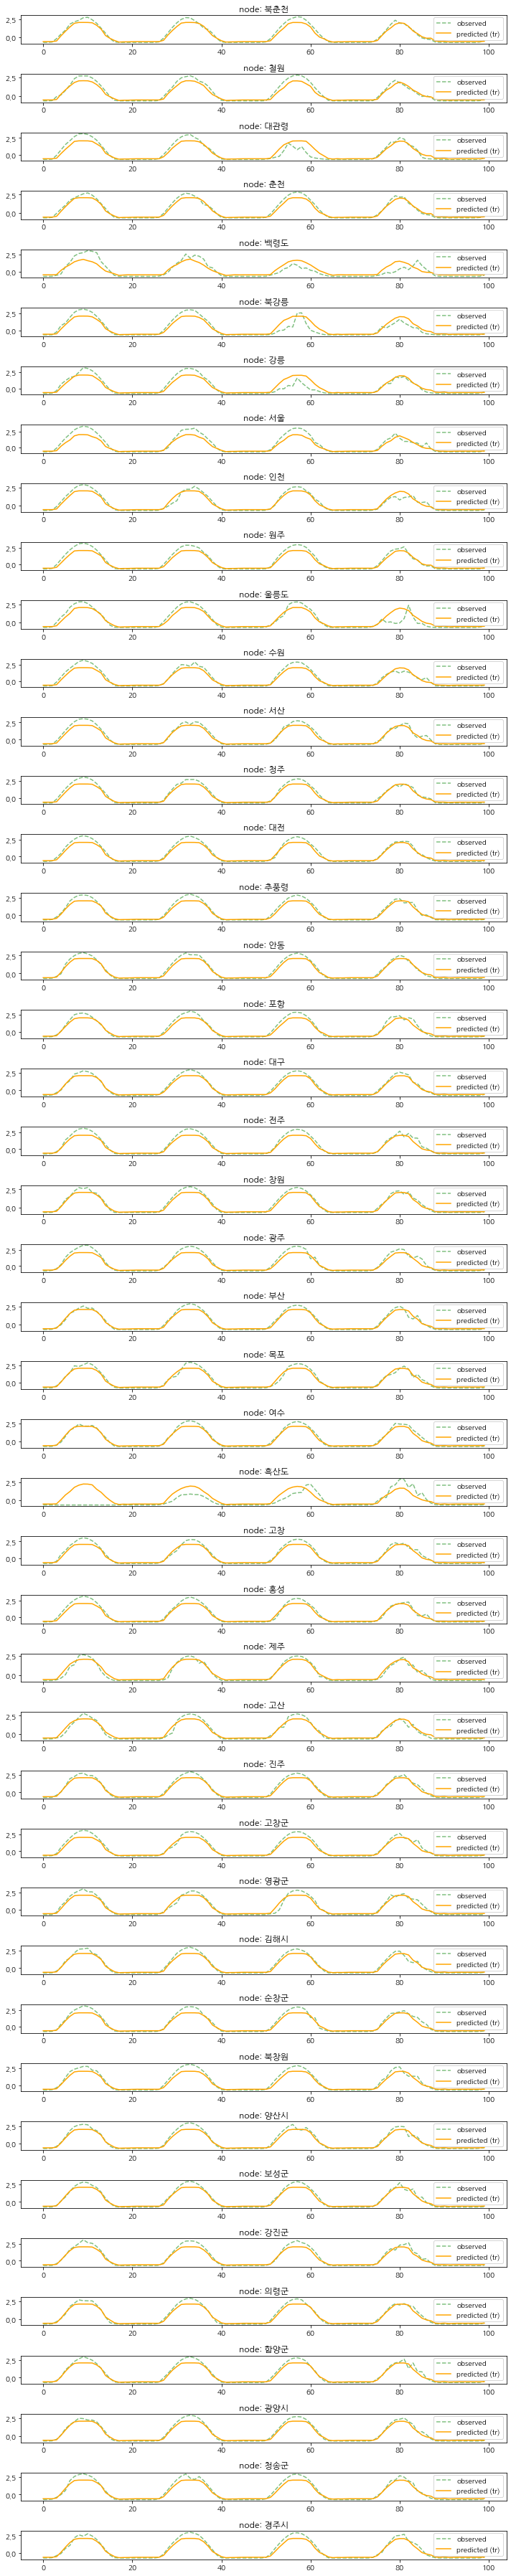

In [20]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0 
T = 100 
for k in range(44):
    ax[k].plot(np.array(train_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed', color='green')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:T,k],label='predicted (tr)', color = 'orange')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')

In [21]:
np.array(dataset.features).shape

(2564, 44, 4)

In [22]:
np.array(dataset.targets).shape

(2564, 44)

In [23]:
np.array(train_dataset.targets).shape

(1794, 44)

In [24]:
np.array(test_dataset.targets).shape

(770, 44)

### test

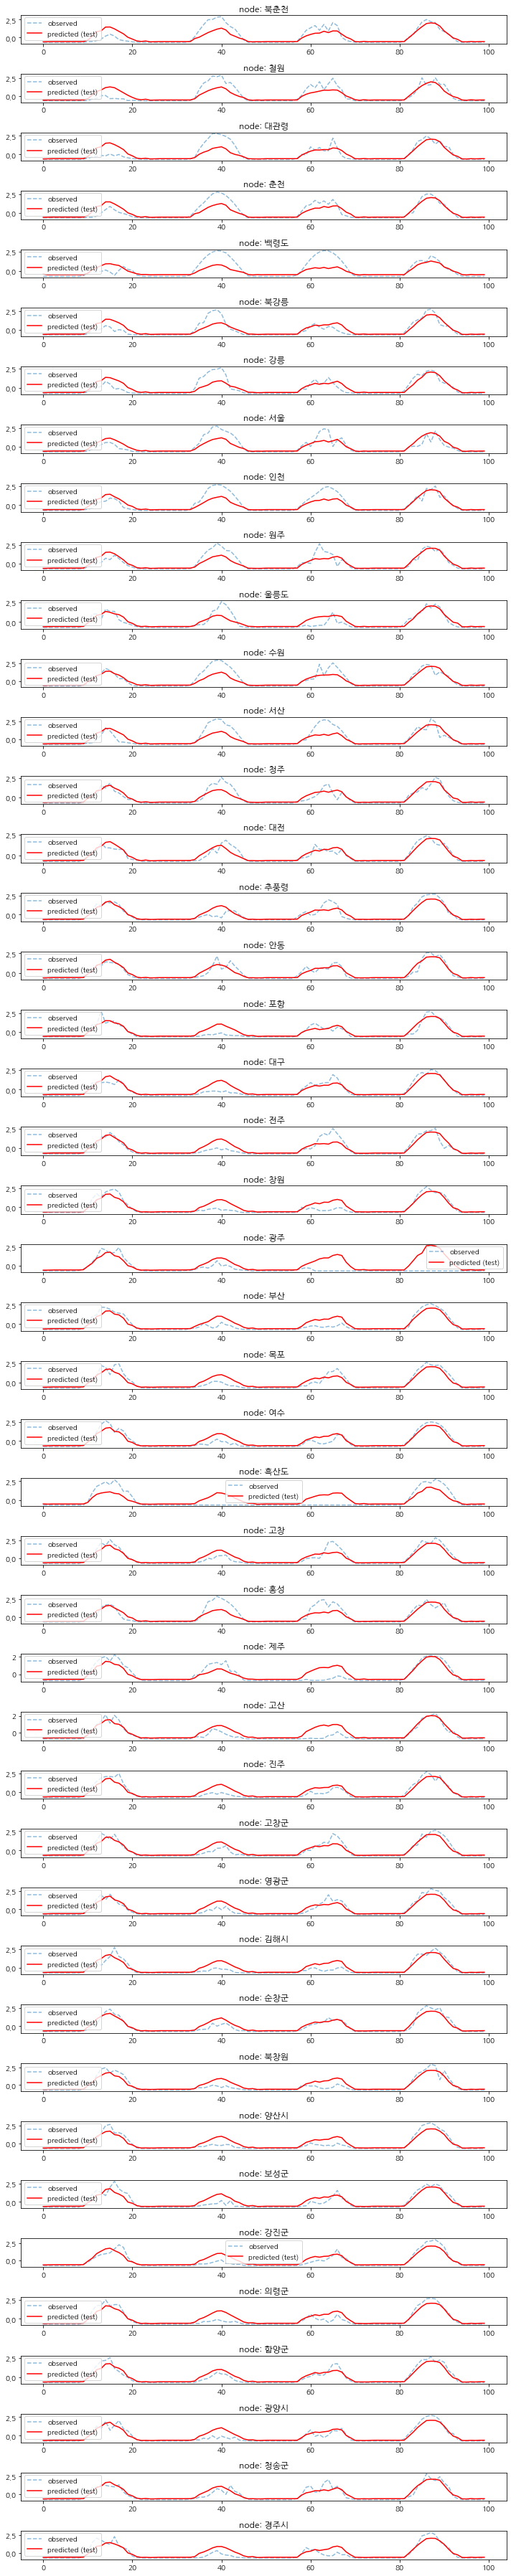

In [25]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0
T = 100 
for k in range(44):
    ax[k].plot(np.array(test_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_test[:T,k],label='predicted (test)', color='red')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')